In [80]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from glob import iglob
import csv
import os
from cassandra import *
from cassandra.query import *
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk import pos_tag
import string
import re
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier
from pyspark.ml.clustering import LDA
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.types import ArrayType, StringType

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages  com.datastax.spark:spark-cassandra-connector_2.12:3.0.1 --conf spark.cassandra.connection.host=127.0.0.1 pyspark-shell\
                                    --driver-memory 3g --executor-memory 3g'

spark = SparkSession.builder\
        .config('spark.cassandra.connection.host', '172.18.0.2') \
        .config('spark.cassandra.connection.port', '9042') \
        .appName("PySparkCassandra")\
        .master("local[6]")\
        .getOrCreate()

In [1]:
# !pip install WordCloud
# !pip install TextBlob
# !pip install nltk
# !pip install papermill
# !pip install scheduler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.6/363.6 KB 3.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 KB 4.7 MB/s eta 0:00:00a 0:00:01


In [3]:
# create the schema for the csv files and store them
from pyspark.sql.types import *
import time

data_schema = [
    StructField("id", IntegerType(), True),
    StructField("userid", IntegerType(), True),
    StructField("username", StringType(), True),
    StructField("acctdesc", StringType(), True),
    StructField("location", StringType(), True),
    StructField("following", IntegerType(), True),
    StructField("followers", IntegerType(), True),
    StructField("totaltweets", IntegerType(), True),
    StructField("usercreatedts", TimestampType(), True),
    StructField("tweetid", IntegerType(), True),
    StructField("tweetcreatedts", TimestampType(), True),
    StructField("retweetcount", IntegerType(), True),
    StructField("text", IntegerType(), True),
    StructField("hashtags", StringType(), True),
    StructField("language", StringType(), True),
    StructField("coordinates", DecimalType(), True),
    StructField("favorite_count", IntegerType(), True),
    StructField("extractedts", TimestampType(), True)
]

final_struct = StructType(fields = data_schema)

start = time.time()
csv_files = "./Ukraine Test File/"

try:
    df = spark.read\
        .option("delimiter",",")\
        .option("header","true")\
        .option("multiline", "true")\
        .option("escape", "\t")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .option("schema", "final_struct")\
        .csv(csv_files)
except Exception as e:
    print(e)

# end time
end = time.time()
print(f"Reading multiple csv files took {end - start}")

Reading multiple csv files took 0.06803083419799805


In [4]:
# rename _c0 to id
df = df.withColumnRenamed("_c0","id")

In [5]:
# connect to cassandra db to create the table to store in
from cassandra.cluster import Cluster
try:
    cluster = Cluster(['cass_dbap'])
    session = cluster.connect()
    print("Connection Established!")
except Exception as e:
    print("Connection Failed...")

Connection Established!


In [62]:
createTweetsKeyspace = """
CREATE KEYSPACE IF NOT EXISTS dbap
  WITH replication = {'class': 'SimpleStrategy', 'replication_factor' : 1};
"""
session.execute(createTweetsKeyspace)

In [ ]:
# Create the table to store our raw data to
createTable = """
CREATE TABLE IF NOT EXISTS dbap.raw_db(
    id bigint,
    userid bigint,
    username text,
    acctdesc text,
    location text,
    following int,
    followers int,
    totaltweets int,
    usercreatedts timestamp,
    tweetid bigint,
    tweetcreatedts timestamp,
    retweetcount int,
    text text,
    hashtags text,
    language text,
    coordinates text,
    favorite_count int,
    extractedts timestamp,
    PRIMARY KEY(tweetid, username)
);
"""
session.execute(createTable)

In [ ]:
# main raw_db1 that contains all raw data
# Use a prepared statement
insertRecord = """
INSERT INTO DBAP.raw_db1 (id, userid, username, acctdesc, location, following, followers, totaltweets, usercreatedts, tweetid, tweetcreatedts, retweetcount, text, hashtags, language, coordinates, favorite_count, extractedts)
   VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s) IF NOT EXISTS;
"""
# read all csv files
csv_files = "./Ukraine Test File/*.csv"

start = time.time()
# go through each csv file

try:
    for file in iglob(csv_files):
        sum = 0.0
        n = 0 # number of terms going into the sum
        with open(file) as f:
                reader = csv.reader(f)
                # skip the header
                next(reader)  
                for row in reader:
                    id = int(row[0])
                    userid = int(row[1])
                    username = str(row[2])
                    acctdesc = str(row[3])
                    location = str(row[4])
                    following = int(row[5])
                    followers = int(row[6])
                    totaltweets = int(row[7])
                    usercreatedts = str(row[8])
                    tweetid = int(row[9])
                    tweetcreatedts = str(row[10])
                    retweetcount = int(row[11])
                    text = str(row[12])
                    hashtags = str(row[13])
                    language = str(row[14])
                    coordinates = str(row[15])
                    favorite_count = int(row[16])
                    extractedts = str(row[17])
                    # Create a tuple of values to insert into the raw_db1 table using the prepared statement
                    insertValues = (id, userid, username, acctdesc, location, following, followers, totaltweets, usercreatedts, tweetid, tweetcreatedts, retweetcount, text, hashtags, language, coordinates, favorite_count, extractedts)
                    session.execute(insertRecord, insertValues)
except Exception as e:
    print(e)
# end time
end = time.time()
print(f"Reading and writing csv file to db took {end - start}")

# Reading and writing csv file to db took 292.65440464019775 240mb csv file


In [81]:
# Since our data is now loaded, we do no need it in the current directory and will be moved to a folder called Old
import glob, os, shutil
csv_files = "./Ukraine Test File/*.csv"
transferTo = "./Ukraine Test File/Old"
    # This iterate through files that have .csv format then moves them to the transferTo folder
    for file in glob.glob(csv_files):
        shutil.move(file, transferTo)
except Exception as e:
    print(e)    

In [7]:
# Now that our raw data is stored we can query the raw data 
raw_data = spark.read\
        .format("org.apache.spark.sql.cassandra")\
        .options(table='raw_db1', keyspace='dbap')\
        .load()

In [11]:
# 397,197 rows
raw_data.count()

397197

In [8]:
## Sentiment Analysis ##

# only take tweetid and text for sentiment analysis and english language
text_sa = raw_data.select('tweetid', 'tweetcreatedts', 'text').where(raw_data.language=='en')

In [65]:
#273342
text_sa.count()

273342

In [64]:
# This removes emojis and other characters that are not expected
def strip_sc(words):
    try:
        cleaned = (l for l in words if 0<ord(l)<127)
        return ''.join(cleaned)
    except Exception as e:
        print(e)

# setup pyspark udf function
strip_sc_udf = udf(strip_sc, StringType())

In [11]:
text_sa = text_sa.withColumn('stripped_special',strip_special_chars_udf(text_sa['text']))
text_sa.show(5,True)

+-------------------+-------------------+--------------------+--------------------+
|            tweetid|     tweetcreatedts|                text|    stripped_special|
+-------------------+-------------------+--------------------+--------------------+
|1516929261717884936|2022-04-20 23:58:13|My bed is shaking...|My bed is shaking...|
|1516793734347866124|2022-04-20 14:59:41|Mekelle is curren...|Mekelle is curren...|
|1516726559691968514|2022-04-20 10:32:45|Kids #Ukraine️ #S...|Kids #Ukraine #St...|
|1516839246019149830|2022-04-20 18:00:32|Spoke to Svyatosl...|Spoke to Svyatosl...|
|1516690995332661250|2022-04-20 08:11:26|#Twitter has susp...|#Twitter has susp...|
+-------------------+-------------------+--------------------+--------------------+
only showing top 5 rows



In [65]:
def lower_and_strip(data):
    try:
        data = data.lower()
        data = data.strip()
        return data
    except Exception as e:
        print(e)

lower_and_strip_udf = udf(lower_and_strip, StringType())

In [13]:
text_sa = text_sa.withColumn('lower_stripped',lower_and_strip_udf(text_sa['stripped_special']))
text_sa.show(5,True)

+-------------------+-------------------+--------------------+--------------------+--------------------+
|            tweetid|     tweetcreatedts|                text|    stripped_special|      lower_stripped|
+-------------------+-------------------+--------------------+--------------------+--------------------+
|1516904494755418112|2022-04-20 22:19:48|The humanitarian ...|The humanitarian ...|the humanitarian ...|
|1516759442930515974|2022-04-20 12:43:25|#Bucha #BuchaMass...|#Bucha #BuchaMass...|#bucha #buchamass...|
|1516870578740858880|2022-04-20 20:05:02|@lapatina_ 1/3 We...|@lapatina_ 1/3 We...|@lapatina_ 1/3 we...|
|1516840437587144704|2022-04-20 18:05:16|The sun goes down...|The sun goes down...|the sun goes down...|
|1516829537971044356|2022-04-20 17:21:57|Join us for a wid...|Join us for a wid...|join us for a wid...|
+-------------------+-------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [14]:
def remove_extras(data):
    try:
        # regex commands to clean data
        rm_https = re.compile('https?:\/\/\S+')
        rm_http = re.compile('http?:\/\/\S+')
        rm_punc = re.compile('[^\w\s]')
        rm_num = re.compile('(\d+)')
        rm_mention = re.compile('@\w+')
        rm_digit = re.compile('\d+')
        # lowercase
        data = data.lower()
        # hyperlinks
        data = rm_https.sub(' ', data)
        data = rm_http.sub(' ', data)
        # mentions
        data = rm_mention.sub(' ', data)
        # puncuations
        data = rm_punc.sub(' ', data)
        # digits
        data = rm_num.sub(' ', data)
        return " ".join(data.split())
    except Exception as e:
        print(e)
# setup pyspark udf function
remove_extras_udf = udf(remove_extras, StringType())

In [15]:
text_sa = text_sa.withColumn('cleaned',remove_extras_udf(text_sa['lower_stripped']))
text_sa.show(5,True) 

+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|            tweetid|     tweetcreatedts|                text|    stripped_special|      lower_stripped|             cleaned|
+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|1516650070346588160|2022-04-20 05:28:49|#Taiwan is proud ...|#Taiwan is proud ...|#taiwan is proud ...|taiwan is proud t...|
|1516644482493685760|2022-04-20 05:06:37|#Ukraine received...|#Ukraine received...|#ukraine received...|ukraine received ...|
|1516568869200183300|2022-04-20 00:06:09|"I dug up my daug...|"I dug up my daug...|"i dug up my daug...|i dug up my daugh...|
|1516776324399984640|2022-04-20 13:50:30|And another artic...|And another artic...|and another artic...|and another artic...|
|1516679430915121153|2022-04-20 07:25:29|While all eyes ar...|While all eyes ar...|while all eyes ar...|while all eyes

In [ ]:
# A decision was made to not remove stop words as it adds value to the data

# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # removes stop words
# def rm_sw(data):
#     tokens = word_tokenize(data)
#     tokens_cleaned = [word for word in text_tokens if not word in stopwords.words()]
#     cleaned = (" ").join(tokens_cleaned)
#     return cleaned

# rm_sw_udf = udf(rm_sw, StringType())

# text_sa = text_sa.withColumn('removed_stopwords',rm_sw_udf(text_sa['removed']))
# text_sa.show(5)

In [66]:
from pyspark.sql.types import FloatType
from textblob import TextBlob
def get_sentiment(tweet):
    try:
        return TextBlob(tweet).sentiment.polarity
    except Exception as e:
        print(e)
get_sentiment_udf = udf(get_sentiment , FloatType())

In [17]:
text_sa = text_sa.withColumn("sentiment_score", get_sentiment_udf( text_sa['cleaned']))
text_sa.show(5,True)

+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|            tweetid|     tweetcreatedts|                text|    stripped_special|      lower_stripped|             cleaned|sentiment_score|
+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|1516634000277704704|2022-04-20 04:24:58|Something #Russia...|Something #Russia...|something #russia...|something russian...|            0.0|
|1516867279211933713|2022-04-20 19:51:56|@donaldtuskEPP We...|@donaldtuskEPP We...|@donaldtuskepp we...|we germans don t ...|            0.0|
|1516713638526013441|2022-04-20 09:41:25|Mobile networks, ...|Mobile networks, ...|mobile networks, ...|mobile networks f...|            0.1|
|1516631208117080072|2022-04-20 04:13:52|HOTBIX FREESTYLE ...|HOTBIX FREESTYLE ...|hotbix freestyle ...|hotbix freestyle ...|            0.0|
|15166

In [67]:
def pnn(score):
    try:
        if (score >0.0):
            sentiment_val = "positive"
        elif(score < 0.0):
            sentiment_val = "negative"
        else:
            sentiment_val = "neutral"
        return sentiment_val
    except Exception as e:
        print(e)
pnn_udf = udf(lambda x: pnn(x), StringType())

In [68]:
text_sa = text_sa.withColumn("sentiment", pnn_udf( text_sa['sentiment_score']))
text_sa.show(5,True)

+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------+---------+
|            tweetid|     tweetcreatedts|                text|    stripped_special|      lower_stripped|             cleaned|sentiment_score|sentiment|
+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------+---------+
|1516650070346588160|2022-04-20 05:28:49|#Taiwan is proud ...|#Taiwan is proud ...|#taiwan is proud ...|taiwan is proud t...|            0.8| positive|
|1516644482493685760|2022-04-20 05:06:37|#Ukraine received...|#Ukraine received...|#ukraine received...|ukraine received ...|            0.0|  neutral|
|1516568869200183300|2022-04-20 00:06:09|"I dug up my daug...|"I dug up my daug...|"i dug up my daug...|i dug up my daugh...|           -0.1| negative|
|1516776324399984640|2022-04-20 13:50:30|And another artic...|And another artic...|and a

In [20]:
text_sa2 = text_sa.select('tweetid', 'tweetcreatedts', 'cleaned', 'sentiment_score', 'sentiment')
# Rename columns to match table
text_sa2 = text_sa2.withColumnRenamed("cleaned", "text")
text_sa3= text_sa2.select('cleaned', 'sentiment')

In [ ]:
text_sa3.groupBy('sentiment').count().show()
# +---------+------+
# |sentiment| count|
# +---------+------+
# | positive|119980|
# |  neutral| 76582|
# | negative| 76780|
# +---------+------+


In [44]:
# Create the table to store our process data
createTable = """
CREATE TABLE IF NOT EXISTS dbap.sa_processed(
    tweetid bigint,
    tweetcreatedts timestamp,
    text text,
    sentiment_score float,
    sentiment text,
    PRIMARY KEY(tweetid, tweetcreatedts)
);
"""
session.execute(createTable)

In [ ]:
# Store processed data to DB
text_sa2.write\
        .format("org.apache.spark.sql.cassandra")\
        .mode('append')\
        .options(table="sa_processed", keyspace="dbap")\
        .save()

In [99]:
sentiment_col = text_sa2.select('sentiment').toPandas()

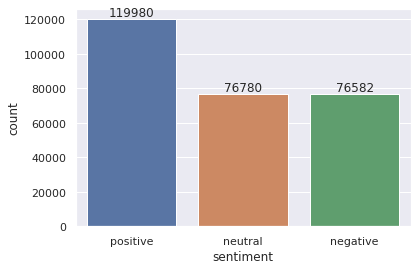

In [136]:
import seaborn as sns

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="sentiment", data=sentiment_col)
abs_values = sentiment_col['sentiment'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
timestr = time.strftime("%Y%m%d-%H%M%S")
sa_count = "sa_count" + timestr + ".png"
pathFile = "./Ukraine Test File/Analysis/" + sa_count
ax.figure.savefig(pathFile)

In [109]:
text_tweets = text_sa2.select('tweetcreatedts', 'text').toPandas()

In [121]:
text_tweets['hour'] = pd.to_datetime(text_tweets['tweetcreatedts'], format='%H:%M:%S')
text_tweets['hour'] = text_tweets['hour'].dt.hour


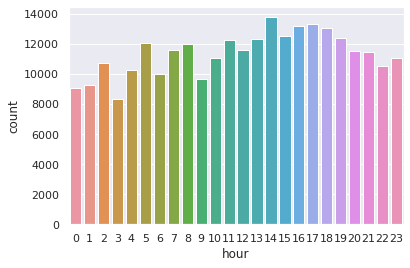

In [135]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="hour", data=text_tweets)
abs_values = text_tweets['hour'].value_counts(ascending=False).values
timestr = time.strftime("%Y%m%d-%H%M%S")
tw_count = "tw_count" + timestr + ".png"
pathFile = "./Ukraine Test File/Analysis/" + tw_count
ax.figure.savefig(pathFile)


In [123]:
text_tweets.head()

,tweetcreatedts,text,hour
0,2022-04-20 05:28:49,taiwan is proud to stand in solidarity with th...,5
1,2022-04-20 05:06:37,ukraine received fighter planes and aircraft p...,5
2,2022-04-20 00:06:09,i dug up my daughter from the stones my grandk...,0
3,2022-04-20 13:50:30,and another article regarding lgbtq life in uk...,13
4,2022-04-20 07:25:29,while all eyes are rightly on ukraine it is im...,7


In [90]:
# use for word cloud
text_col = text_sa2.select('text').toPandas()

In [91]:
# plot words for word cloud
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

combined_tweets = " ".join(text for text in text_col['text'])

In [92]:
custom_stopwords = list(STOPWORDS)+ list(stopwords.words('english')) + \
                ['s','see','took', 'dont', 'kg', 'son', 'took', 'tag', 'mariupol', 'keepiton', 'reconnecttigray']

In [93]:
tweet_wordcloud =  WordCloud(stopwords=custom_stopwords,
                            background_color='white', width=4000, height=2000,
                            max_words=500).generate(combined_tweets)

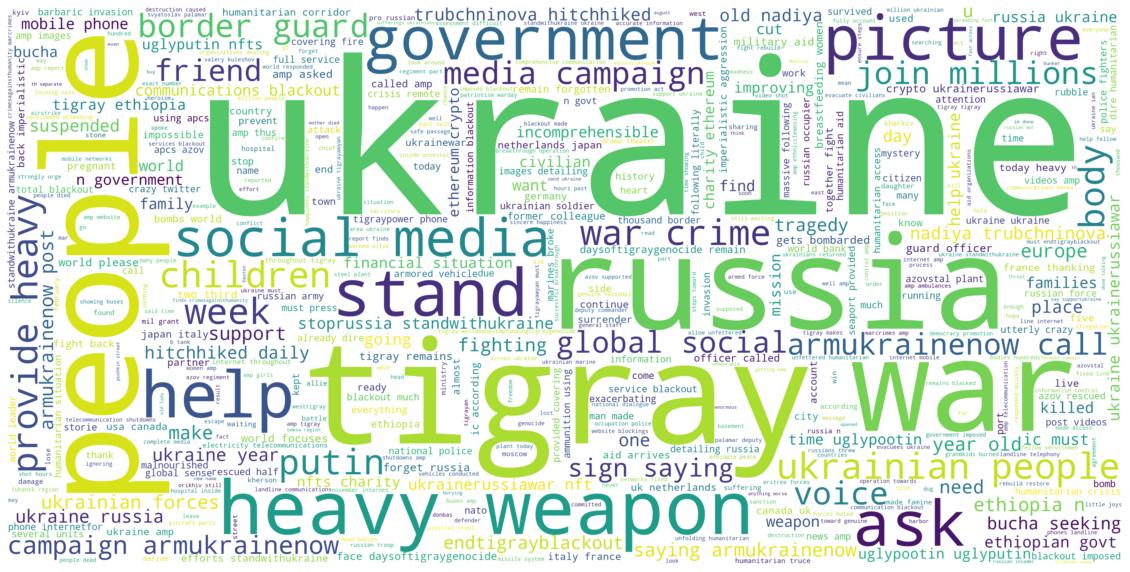

In [137]:
plt.figure(figsize=(20,15))
plt.imshow(tweet_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show
# Save file for report
timestr = time.strftime("%Y%m%d-%H%M%S")
wordCloud = "wordcloud" + timestr + ".png"
pathFile = "./Ukraine Test File/Analysis/" + wordCloud
plt.savefig(pathFile)

In [27]:
##### train test sentiment analysis #####
sa_val = text_sa2.select('text', 'sentiment').toPandas()

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# Split the data to train and test
x_train, x_test, y_train, y_test = train_test_split(sa_val['text'], sa_val['sentiment'], test_size = 0.20, random_state = 69)

In [33]:
start = time.time()
# using HashingVectorizer instead of CountVectorizer as it is more efficient and does not crash computer
vec = HashingVectorizer(alternate_sign=False)
x_train_vec = vec.fit_transform(x_train)
x_test_vec = vec.transform(x_test)

# Fit the model in naivebayes
nb = MultinomialNB()
cls_score = nb.fit(x_train_vec, y_train)
y_predict = cls_score.predict(x_test_vec)
# end time
end = time.time()
print(f"getting sentinment analysis took {end - start}")

Reading and writing csv file to db took 3.695708751678467


In [34]:
from sklearn import metrics
# return accuracy
metrics.accuracy_score(y_test, y_predict)
# 07471510362362582 accuracy score
# or 0.75 rounded off

0.7471510362362582

In [42]:
# try to improve our model by removing stopword. Use the custom stopwords used before

start = time.time()
vec = HashingVectorizer( stop_words=stopwords.words('english'), alternate_sign=False)
x_train_vec = vec.fit_transform(x_train)
x_test_vec = vec.transform(x_test)
# Fit the model in naivebayes
nb = MultinomialNB()
cls_score = nb.fit(x_train_vec, y_train)
y_predict = cls_score.predict(x_test_vec)
end = time.time()
print(f"getting sentinment analysis took {end - start}")

getting sentinment analysis took 3.709688663482666


In [43]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_predict)
# 0.7881248971080502 accuracy score improved by 4%
# or 0.79 rounded off

0.7881248971080502

In [39]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_predict)
# array([[10757,   124,  4497], Negative
#        [  297,  8609,  6486], Neutral
#        [  137,    42, 23720]]) Positive

array([[10757,   124,  4497],
       [  297,  8609,  6486],
       [  137,    42, 23720]])

In [40]:
print(y_test.value_counts())

positive    23899
neutral     15392
negative    15378
Name: sentiment, dtype: int64


In [ ]:
######### LDA pipeline #########

In [44]:
lda_tm = text_sa2.select('text')

In [53]:
# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and
# Create a pipeline using PySpark ML which will tokenize, idf and LDA to topic model
start = time.time()
#data = tokenizer.transform(data)
tk = Tokenizer(inputCol="text", outputCol="tkWords")
vec = CountVectorizer(inputCol= "tkWords", outputCol="vecWordsRF")
idf = IDF(inputCol="vecWordsRF", outputCol="features")
#idfModel = idf.fit(data)
lda = LDA(k=10, maxIter=10, seed=1, optimizer="em")
pipeline = Pipeline(stages=[tk, vec, idf, lda])
model = pipeline.fit(lda_tm)
end = time.time()

print(f"pipeline processing took {end - start}")

# pipeline processing took 210.70364785194397

pipeline processing took 210.70364785194397


In [106]:
# This gets the terms along with the termsindices
def getTerms(getV):
    def getTerms(getTI):
        return[getV[int(index)]for index in getTI]
    return udf(getTerms, ArrayType(StringType()))

In [83]:
# Begin pulling the information to build the data into a dataframe for displaying
start = time.time()
vectorizerModel = model.stages[1]
listVocab = vectorizerModel.vocabulary
topics = model.stages[3].describeTopics(5)
finished = topics.withColumn("Terms", getTerms(listVocab)("termIndices"))
end = time.time()
print(f"getting topics took {end - start}")
# getting topics took 0.22033381462097168

getting topics took 0.22033381462097168


In [108]:
finished.select('*').show(truncate=0)

+-----+---------------+---------------------------------------------------------------------------------------------------------------+---------------------+
|topic|termIndices    |termWeights                                                                                                    |Terms                |
+-----+---------------+---------------------------------------------------------------------------------------------------------------+---------------------+
|0    |[2, 1, 3, 6, 0]|[0.005050350748568013, 0.004819293974663548, 0.004781267539653688, 0.0045456903249202355, 0.004324337083528464]|[of, to, and, a, the]|
|1    |[2, 1, 6, 3, 4]|[0.005080065996166942, 0.004855577718464162, 0.004670768377479366, 0.004655060750559819, 0.00425070125612336]  |[of, to, a, and, in] |
|2    |[2, 1, 6, 3, 0]|[0.005137667828563857, 0.004888743754338072, 0.004695238615434184, 0.004658803387220464, 0.0043383017682608]   |[of, to, a, and, the]|
|3    |[2, 1, 6, 3, 7]|[0.005045873210689697, 0.0048

In [134]:
# loc = "./Ukraine Test File/Analysis"
# Save file to folder with timestamp attached appended to filename
final_pd = finished.toPandas()
timestr = time.strftime("%Y%m%d-%H%M%S")
fileName = "lda_topics" + timestr + ".csv"
pathFile = "./Ukraine Test File/Analysis/" + fileName
final_pd.to_csv(pathFile, index = True, header=True)